In [1]:
from google.colab import drive
drive.mount('/content/drive')

# from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import random

# Cell 3: Global Configuration
np.random.seed(42)
random.seed(42)
plt.style.use('seaborn-v0_8')
%matplotlib inline

TITANIC_PATH = '/content/drive/MyDrive/CS289/hw5/titanic/'
SPAM_PATH = '/content/drive/MyDrive/CS289/hw5/spam_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
titanic_train = pd.read_csv(TITANIC_PATH + 'titanic_training.csv')
print('Titanic Training Data:')
print(f'Shape: {titanic_train.shape}')
print(f'Columns: {list(titanic_train.columns)}')
print()
print('First 5 rows:')
print(titanic_train.head())
print()
print('Missing values:')
print(titanic_train.isnull().sum())
print()
print('=' * 50)
print()

titanic_test = pd.read_csv(TITANIC_PATH + 'titanic_testing_data.csv')
print('Titanic Testing Data:')
print(f'Shape: {titanic_test.shape}')
print(f'Columns: {list(titanic_test.columns)}')
print()
print('First 5 rows:')
print(titanic_test.head())
print()
print('Missing values:')
print(titanic_test.isnull().sum())

Titanic Training Data:
Shape: (1000, 10)
Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']

First 5 rows:
   survived  pclass   sex   age  sibsp  parch           ticket      fare  \
0       0.0     3.0  male   NaN    0.0    0.0  SOTON/OQ 392086    8.0500   
1       0.0     1.0  male  22.0    0.0    0.0         PC 17760  135.6333   
2       0.0     2.0  male  23.0    0.0    0.0    SC/PARIS 2133   15.0458   
3       0.0     2.0  male  42.0    0.0    0.0           211535   13.0000   
4       0.0     3.0  male  20.0    0.0    0.0             7534    9.8458   

  cabin embarked  
0   NaN        S  
1   NaN        C  
2   NaN        C  
3   NaN        S  
4   NaN        S  

Missing values:
survived      1
pclass        1
sex           1
age         196
sibsp         1
parch         1
ticket        1
fare          2
cabin       773
embarked      3
dtype: int64


Titanic Testing Data:
Shape: (310, 9)
Columns: ['pclass', 'sex', 'age', 'sibsp

In [3]:
spam_data = loadmat(SPAM_PATH + 'spam_data.mat')
print('Keys in spam_data.mat:')
print(list(spam_data.keys()))
print()

for key in spam_data.keys():
    if not key.startswith('__'):
        data = spam_data[key]
        print(f'{key}:')
        print(f'  Type: {type(data)}')
        print(f'  Shape: {data.shape if hasattr(data, "shape") else "N/A"}')
        if hasattr(data, 'dtype'):
            print(f'  Data type: {data.dtype}')
        print()

if 'training_data' in spam_data:
    print('Training data shape:', spam_data['training_data'].shape)
if 'training_labels' in spam_data:
    print('Training labels shape:', spam_data['training_labels'].shape)
    print('Unique labels:', np.unique(spam_data['training_labels']))
if 'test_data' in spam_data:
    print('Test data shape:', spam_data['test_data'].shape)

Keys in spam_data.mat:
['__header__', '__version__', '__globals__', 'test_data', 'training_data', 'training_labels']

test_data:
  Type: <class 'numpy.ndarray'>
  Shape: (5857, 32)
  Data type: float64

training_data:
  Type: <class 'numpy.ndarray'>
  Shape: (5172, 32)
  Data type: float64

training_labels:
  Type: <class 'numpy.ndarray'>
  Shape: (1, 5172)
  Data type: int64

Training data shape: (5172, 32)
Training labels shape: (1, 5172)
Unique labels: [0 1]
Test data shape: (5857, 32)


In [ ]:
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_titanic(df_train, df_test):
    df_train = df_train.copy()
    df_test = df_test.copy()

    # Separate target variable
    y_train = df_train['survived']
    X_train = df_train.drop('survived', axis=1)
    X_test = df_test.copy() 

    # --- Feature Engineering ---

    # Title feature
    for df in [X_train, X_test]:
        df['ticket_str'] = df['ticket'].astype(str)
        df['title'] = df['ticket_str'].apply(lambda x: re.search(r' ([A-Za-z]+)\.', str(x)).group(1) if re.search(r' ([A-Za-z]+)\.', str(x)) else "")
        df['title'] = df['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        df['title'] = df['title'].replace('Mlle', 'Miss')
        df['title'] = df['title'].replace('Ms', 'Miss')
        df['title'] = df['title'].replace('Mme', 'Mrs')
        df.drop('ticket_str', axis=1, inplace=True) # Drop the temporary column


    # Impute missing 'age' before creating age bins
    for df in [X_train, X_test]:
        df['age'] = df.groupby(['pclass', 'sex'])['age'].transform(lambda x: x.fillna(x.median()))

    # Age Bins - Creating categorical features from age
    for df in [X_train, X_test]:
        df['age_bin'] = pd.cut(df['age'], bins=[0, 12, 18, 60, np.inf], labels=['child', 'teenager', 'adult', 'senior'], right=False)

    # FamilySize
    for df in [X_train, X_test]:
        df['family_size'] = df['sibsp'] + df['parch'] + 1

    # IsAlone
    for df in [X_train, X_test]:
        df['is_alone'] = (df['family_size'] == 1).astype(int)

    # HasFamily
    for df in [X_train, X_test]:
        df['has_family'] = (df['family_size'] > 1).astype(int)

    # Deck
    for df in [X_train, X_test]:
        df['deck'] = df['cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else 'Unknown')

    # Fare per person - handle potential division by zero
    for df in [X_train, X_test]:
        df['fare_per_person'] = df['fare'] / df['family_size']
        df['fare_per_person'] = df['fare_per_person'].replace([np.inf, -np.inf], np.nan) 

    # Fare Bins
    for df in [X_train, X_test]:
        df['fare_bin'] = pd.qcut(df['fare'], q=4, labels=False, duplicates='drop') 


    # Drop original features that are now represented by engineered features or are not useful
    for df in [X_train, X_test]:
        df.drop(['ticket', 'cabin', 'sibsp', 'parch', 'age', 'fare'], axis=1, inplace=True)


    # --- Preprocessing Pipelines ---

    # Identify categorical and numerical features 
    categorical_features = ['pclass', 'sex', 'embarked', 'title', 'deck', 'age_bin', 'fare_bin']
    numerical_features = ['family_size', 'is_alone', 'has_family', 'fare_per_person']

    # Create preprocessing pipelines for numerical and categorical features
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    # Fit the preprocessor on the training data only
    preprocessor.fit(X_train)

    # Apply preprocessing to training and testing data
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)


    return X_train_processed, y_train, X_test_processed

def preprocess_spam(spam_data):
    spam_train_X = spam_data['training_data']
    spam_train_y = spam_data['training_labels'].flatten() # Flatten labels to 1D array
    spam_test_X = spam_data['test_data']

    scaler = StandardScaler()
    spam_processed_train_X = scaler.fit_transform(spam_train_X)
    spam_processed_test_X = scaler.transform(spam_test_X)

    # No text-based features to add as data is already numerical features

    return spam_processed_train_X, spam_train_y, spam_processed_test_X


# Drop rows with missing 'survived' values from the training data before preprocessing
titanic_train_cleaned = titanic_train.dropna(subset=['survived']).copy()
X_train_titanic, y_train_titanic, X_test_titanic = preprocess_titanic(titanic_train_cleaned, titanic_test)

X_train_spam, y_train_spam, X_test_spam = preprocess_spam(spam_data)

print("Titanic Preprocessing Complete:")
print(f"X_train_titanic shape: {X_train_titanic.shape}")
print(f"y_train_titanic shape: {y_train_titanic.shape}")
print(f"X_test_titanic shape: {X_test_titanic.shape}")
print("-" * 30)
print("Spam Preprocessing Complete:")
print(f"X_train_spam shape: {X_train_spam.shape}")
print(f"y_train_spam shape: {y_train_spam.shape}")
print(f"X_test_spam shape: {X_test_spam.shape}")

Titanic Preprocessing Complete:
X_train_titanic shape: (999, 30)
y_train_titanic shape: (999,)
X_test_titanic shape: (310, 30)
------------------------------
Spam Preprocessing Complete:
X_train_spam shape: (5172, 32)
y_train_spam shape: (5172,)
X_test_spam shape: (5857, 32)


In [5]:
from typing import Optional, Tuple

class Node:
  def __init__(self,
               feature_index: Optional[int] = None,
               threshold: Optional[float] = None,
               left: Optional['Node'] = None,
               right: Optional['Node'] = None,
               value: Optional[int] = None
              ):
    self.feature_index = feature_index
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

In [ ]:
class DecisionTree:
  def __init__(self,
               min_samples_split: int = 5,
               max_depth: int = 15,
               n_features: Optional[int] = None,
               split_criterion: str = 'gini'): 
    self.root = None
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_features = n_features
    if split_criterion not in ['gini', 'entropy']: 
        raise ValueError("split_criterion must be 'gini' or 'entropy'")
    self.split_criterion = split_criterion


  def fit(self, X: np.ndarray, y: np.ndarray) -> None:
    self.root = self._grow_tree(X, y, 0)

  def predict(self, X: np.ndarray) -> np.ndarray:
    return np.array([self._traverse_tree(x, self.root) for x in X])

  def trace(self, x: np.ndarray, feature_names: Optional[list] = None) -> list:
    path = []
    self._trace_path(x, self.root, path, feature_names)
    return path

  def _trace_path(self, x: np.ndarray, node: Node, path: list, feature_names: Optional[list] = None):
    """Helper method to trace the path recursively"""
    if node.value is not None:
      # Leaf node
      # Need to infer the class label based on the context (Spam or Titanic)
      # Assuming for now that 1 is the positive class (spam/survived) and 0 is negative (ham/not survived)
      prediction_label = "positive class" if node.value == 1 else "negative class"
      path.append(f"Therefore this sample was classified as {prediction_label} (label: {node.value}).")
      return

    # Internal node - make a decision
    # Ensure feature_names is a list of strings for consistent formatting
    feature_name = f"feature_{node.feature_index}" if feature_names is None else str(feature_names[node.feature_index])


    if x[node.feature_index] <= node.threshold:
      path.append(f'Feature "{feature_name}" ({x[node.feature_index]:.3f}) <= Threshold {node.threshold:.3f}')
      self._trace_path(x, node.left, path, feature_names)
    else:
      path.append(f'Feature "{feature_name}" ({x[node.feature_index]:.3f}) > Threshold {node.threshold:.3f}')
      self._trace_path(x, node.right, path, feature_names)


  def _grow_tree(self, X: np.ndarray, y: np.ndarray, depth: int=0) -> Node:
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))

    if (n_labels == 1 or
        depth >= self.max_depth or
        n_samples < self.min_samples_split):
      leaf_value = self._most_common_label(y)
      return Node(value=leaf_value)

    feature_index, threshold = self._find_best_split(X, y)
    if feature_index is None:
      leaf_value = self._most_common_label(y)
      return Node(value=leaf_value)

    left_indices, right_indices = self._split_data(X[:, feature_index], threshold)

    if len(left_indices) == 0 or len(right_indices) == 0:
        leaf_value = self._most_common_label(y)
        return Node(value=leaf_value)

    left_node = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1)
    right_node = self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)
    return Node(feature_index=feature_index, threshold=threshold, left=left_node, right=right_node)


  def _find_best_split(self, X: np.ndarray, y: np.ndarray) -> Optional[Tuple[int, float]]:
    best_gain = -1
    best_split = None
    n_total_features = X.shape[1]
    # Use a fixed number of features or sqrt as a heuristic
    num_features_to_consider = self.n_features if self.n_features is not None else int(np.sqrt(n_total_features))
    feature_indices = np.random.choice(n_total_features, num_features_to_consider, replace=False)


    for feature_idx in feature_indices:
      # Consider only a subsample of thresholds for efficiency
      thresholds = np.percentile(X[:, feature_idx], q=np.arange(0, 100, 5)) # Use percentiles as thresholds
      for thr in thresholds:
        if self.split_criterion == 'gini':
            gain = self._gini_gain(X[:, feature_idx], y, thr)
        else: # entropy
            gain = self._information_gain(X[:, feature_idx], y, thr)
        if gain > best_gain:
          best_gain = gain
          best_split = (feature_idx, thr)

    return best_split

  def _information_gain(self, feature_column: np.ndarray, y: np.ndarray, threshold: float) -> float:
    parent_entropy = self._entropy(y)
    left_indices, right_indices = self._split_data(feature_column, threshold)
    if len(left_indices) == 0 or len(right_indices) == 0:
      return 0.0

    n = len(y)
    n_left = len(left_indices)
    n_right = len(right_indices)
    left_entropy = self._entropy(y[left_indices])
    right_entropy = self._entropy(y[right_indices])
    child_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
    return parent_entropy - child_entropy

  def _gini_impurity(self, y: np.ndarray) -> float:
    # Cast y to integer type for np.bincount
    hist = np.bincount(y.astype(int))
    ps = hist / len(y)
    return 1.0 - np.sum(ps**2)

  def _gini_gain(self, feature_column: np.ndarray, y: np.ndarray, threshold: float) -> float:
    parent_gini = self._gini_impurity(y)
    left_indices, right_indices = self._split_data(feature_column, threshold)
    if len(left_indices) == 0 or len(right_indices) == 0:
        return 0.0

    n = len(y)
    n_left = len(left_indices)
    n_right = len(right_indices)
    left_gini = self._gini_impurity(y[left_indices])
    right_gini = self._gini_impurity(y[right_indices])
    child_gini = (n_left / n) * left_gini + (n_right / n) * right_gini
    return parent_gini - child_gini


  def _split_data(self, feature_column: np.ndarray, threshold: float) -> Tuple[np.ndarray, np.ndarray]:
    left_indices = np.where(feature_column <= threshold)[0]
    right_indices = np.where(feature_column > threshold)[0]
    return (left_indices, right_indices)

  def _entropy(self, y: np.ndarray) -> float:
    hist = np.bincount(y.astype(int))
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

  def _most_common_label(self, y: np.ndarray) -> int:
    if len(y) == 0: 
        return 0 
    return np.bincount(y.astype(int)).argmax()


  def _traverse_tree(self, x: np.ndarray, node: Node) -> int:
    if node.value is not None:
      return node.value

    # Check if feature index is valid
    if node.feature_index is None or node.feature_index >= len(x):
        # Fallback to majority class if feature index is invalid
        return self._most_common_label(np.array([self._traverse_tree(x, node.left), self._traverse_tree(x, node.right)]))

    if x[node.feature_index] <= node.threshold:
      return self._traverse_tree(x, node.left)
    else:
      return self._traverse_tree(x, node.right)

In [ ]:
from typing import Optional, Tuple

class RandomForest:
  def __init__(self,
               n_trees: int = 200, 
               max_depth: int = 15, 
               min_samples_split: int = 5,
               n_features: Optional[int] = None,
               split_criterion: str = 'gini' 
               ):
    self.n_trees = n_trees
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.n_features = n_features
    self.n_trees = n_trees
    self.trees = []
    if split_criterion not in ['gini', 'entropy']: 
        raise ValueError("split_criterion must be 'gini' or 'entropy'")
    self.split_criterion = split_criterion

  def fit(self, X: np.ndarray, y: np.ndarray):
    self.trees = []
    n_samples, n_total_features = X.shape
    if self.n_features == None:
      self.n_features = int(np.sqrt(n_total_features))

    for _ in range (self.n_trees):
      tree = DecisionTree(
          max_depth = self.max_depth,
          min_samples_split = self.min_samples_split,
          n_features = self.n_features,
          split_criterion = self.split_criterion
      )

      indices = np.random.choice(n_samples, n_samples, replace=True)
      X_sample, y_sample = X[indices], y[indices]
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)

  def predict(self, X: np.ndarray) -> np.ndarray:
    all_predictions = np.array([tree.predict(X) for tree in self.trees])

    # The shape of all_predictions is (n_trees, n_samples)
    # So we need to transpose it
    predictions_transposed = all_predictions.T
    final_predictions = [self._most_common_label(preds) for preds in predictions_transposed]
    return np.array(final_predictions)

  def _most_common_label(self, y: np.ndarray) -> int:
    # Handle empty predictions array case
    if len(y) == 0:
        return 0 # Or some other default value
    return np.bincount(y.astype(int)).argmax()

Split both the Titanic and Spam training data into 80/20 train/validation sets.


In [ ]:
# Split Titanic data
X_train_titanic_split, X_val_titanic_split, y_train_titanic_split, y_val_titanic_split = train_test_split(
    X_train_titanic, y_train_titanic, test_size=0.2, random_state=42
)

# Split Spam data
X_train_spam_split, X_val_spam_split, y_train_spam_split, y_val_spam_split = train_test_split(
    X_train_spam, y_train_spam, test_size=0.2, random_state=42
)

print("Titanic Data Split Shapes:")
print(f"X_train_titanic_split: {X_train_titanic_split.shape}")
print(f"X_val_titanic_split: {X_val_titanic_split.shape}")
print(f"y_train_titanic_split: {y_train_titanic_split.shape}")
print(f"y_val_titanic_split: {y_val_titanic_split.shape}")
print("-" * 30)
print("Spam Data Split Shapes:")
print(f"X_train_spam_split: {X_train_spam_split.shape}")
print(f"X_val_spam_split: {X_val_spam_split.shape}")
print(f"y_train_spam_split: {y_train_spam_split.shape}")
print(f"y_val_spam_split: {y_val_spam_split.shape}")

Titanic Data Split Shapes:
X_train_titanic_split: (799, 30)
X_val_titanic_split: (200, 30)
y_train_titanic_split: (799,)
y_val_titanic_split: (200,)
------------------------------
Spam Data Split Shapes:
X_train_spam_split: (4137, 32)
X_val_spam_split: (1035, 32)
y_train_spam_split: (4137,)
y_val_spam_split: (1035,)


Train the custom DecisionTree and RandomForest models on the train sets and evaluate their performance (accuracy) on both train and validation sets for both datasets. Report the 8 accuracy scores.


In [ ]:
from sklearn.metrics import accuracy_score

# Drop rows with missing 'survived' values from the training data
titanic_train_cleaned = titanic_train.dropna(subset=['survived']).copy()

# Re-apply preprocessing to the cleaned Titanic data
X_train_titanic_cleaned, y_train_titanic_cleaned, X_test_titanic_cleaned = preprocess_titanic(titanic_train_cleaned, titanic_test.copy())

# Re-split Titanic data and convert y to numpy array
X_train_titanic_split, X_val_titanic_split, y_train_titanic_split_np, y_val_titanic_split_np = train_test_split(
    X_train_titanic_cleaned, y_train_titanic_cleaned.values, test_size=0.2, random_state=42
)

# Split Spam data (y is already a numpy array)
X_train_spam_split, X_val_spam_split, y_train_spam_split_np, y_val_spam_split_np = train_test_split(
    X_train_spam, y_train_spam, test_size=0.2, random_state=42
)


dt_titanic = DecisionTree(max_depth=10, min_samples_split=10)
dt_titanic.fit(X_train_titanic_split, y_train_titanic_split_np)
accuracy_dt_titanic_train = accuracy_score(y_train_titanic_split_np, dt_titanic.predict(X_train_titanic_split))
accuracy_dt_titanic_val = accuracy_score(y_val_titanic_split_np, dt_titanic.predict(X_val_titanic_split))

rf_titanic = RandomForest(n_trees=300, max_depth=10, min_samples_split=10)
rf_titanic.fit(X_train_titanic_split, y_train_titanic_split_np)
accuracy_rf_titanic_train = accuracy_score(y_train_titanic_split_np, rf_titanic.predict(X_train_titanic_split))
accuracy_rf_titanic_val = accuracy_score(y_val_titanic_split_np, rf_titanic.predict(X_val_titanic_split))

dt_spam = DecisionTree(max_depth=15, min_samples_split=5)
dt_spam.fit(X_train_spam_split, y_train_spam_split_np)
accuracy_dt_spam_train = accuracy_score(y_train_spam_split_np, dt_spam.predict(X_train_spam_split))
accuracy_dt_spam_val = accuracy_score(y_val_spam_split_np, dt_spam.predict(X_val_spam_split))

rf_spam = RandomForest(n_trees=300, max_depth=15, min_samples_split=5)
rf_spam.fit(X_train_spam_split, y_train_spam_split_np)
accuracy_rf_spam_train = accuracy_score(y_train_spam_split_np, rf_spam.predict(X_train_spam_split))
accuracy_rf_spam_val = accuracy_score(y_val_spam_split_np, rf_spam.predict(X_val_spam_split))

print(f"Titanic Decision Tree Train Accuracy: {accuracy_dt_titanic_train:.4f}")
print(f"Titanic Decision Tree Validation Accuracy: {accuracy_dt_titanic_val:.4f}")
print(f"Titanic RandomForest Train Accuracy: {accuracy_rf_titanic_train:.4f}")
print(f"Titanic RandomForest Validation Accuracy: {accuracy_rf_titanic_val:.4f}")
print(f"Spam Decision Tree Train Accuracy: {accuracy_dt_spam_train:.4f}")
print(f"Spam Decision Tree Validation Accuracy: {accuracy_dt_spam_val:.4f}")
print(f"Spam RandomForest Train Accuracy: {accuracy_rf_spam_train:.4f}")
print(f"Spam RandomForest Validation Accuracy: {accuracy_rf_spam_val:.4f}")

Titanic Decision Tree Train Accuracy: 0.8436
Titanic Decision Tree Validation Accuracy: 0.8100
Titanic RandomForest Train Accuracy: 0.8360
Titanic RandomForest Validation Accuracy: 0.8000
Spam Decision Tree Train Accuracy: 0.8393
Spam Decision Tree Validation Accuracy: 0.8222
Spam RandomForest Train Accuracy: 0.8467
Spam RandomForest Validation Accuracy: 0.8242


Use the trained DecisionTree on the Spam dataset (80/20 split) to trace and display the decision path for one spam and one ham example from the validation set.


In [ ]:
X_val_spam_split_np = np.array(X_val_spam_split)
y_val_spam_split_np = np.array(y_val_spam_split)

dt_spam_predictions = dt_spam.predict(X_val_spam_split_np)

# Find a correctly predicted spam example 
correct_spam_indices = np.where((dt_spam_predictions == 1) & (y_val_spam_split_np == 1))[0]
if len(correct_spam_indices) > 0:
    spam_sample_index = correct_spam_indices[0]
    spam_sample_data = X_val_spam_split_np[spam_sample_index]
    print("Tracing path for a correctly predicted spam example:")
    spam_path = dt_spam.trace(spam_sample_data)
    for step in spam_path:
        print(step)
else:
    print("Could not find a correctly predicted spam example in the validation set.")

print("-" * 30)

# Find a correctly predicted ham example 
correct_ham_indices = np.where((dt_spam_predictions == 0) & (y_val_spam_split_np == 0))[0]
if len(correct_ham_indices) > 0:
    ham_sample_index = correct_ham_indices[0]
    ham_sample_data = X_val_spam_split_np[ham_sample_index]
    print("Tracing path for a correctly predicted ham example:")
    ham_path = dt_spam.trace(ham_sample_data)
    for step in ham_path:
        print(step)
else:
    print("Could not find a correctly predicted ham example in the validation set.")

Tracing path for a correctly predicted spam example:
Feature "feature_0" (-0.102) <= Threshold -0.102
Feature "feature_28" (0.144) > Threshold -0.342
Feature "feature_27" (-0.215) <= Threshold 0.251
Feature "feature_31" (-0.247) <= Threshold -0.247
Feature "feature_4" (-0.067) <= Threshold -0.067
Feature "feature_5" (-0.094) <= Threshold -0.094
Feature "feature_6" (-0.126) <= Threshold -0.126
Feature "feature_24" (-0.357) <= Threshold 2.834
Feature "feature_3" (-0.177) <= Threshold -0.177
Feature "feature_19" (-0.262) <= Threshold -0.262
Feature "feature_24" (-0.357) <= Threshold 1.238
Feature "feature_9" (-0.097) <= Threshold -0.097
Feature "feature_12" (-0.255) <= Threshold 1.693
Feature "feature_15" (-0.260) <= Threshold -0.260
Feature "feature_16" (-0.216) <= Threshold -0.216
Therefore this sample was classified as positive class (label: 1).
------------------------------
Tracing path for a correctly predicted ham example:
Feature "feature_0" (-0.102) <= Threshold -0.102
Feature "f

Train the custom DecisionTree on the Spam dataset (80/20 split) with varying `max_depth` (1 to 40), plot validation accuracy vs. `max_depth`, identify the best depth, and provide an analysis.


In [ ]:
# Generate predictions for Titanic using the best model (Random Forest based on validation accuracy)
titanic_rf = RandomForest()
titanic_rf.fit(X_train_titanic_cleaned, y_train_titanic_cleaned.values)
titanic_test_predictions = titanic_rf.predict(X_test_titanic_cleaned)

def generate_submission(testing_data, predictions, dataset="titanic"):
    assert dataset in ["titanic", "spam"], f"dataset should be either 'titanic' or 'spam'"
    # This code below will generate the predictions.csv file.
    if isinstance(predictions, np.ndarray):
        predictions = predictions.astype(int)
    else:
        predictions = np.array(predictions, dtype=int)
    assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
    df = pd.DataFrame({'Category': predictions})
    df.index += 1  # Ensures that the index starts at 1.
    df.to_csv(f'predictions_{dataset}.csv', index_label='Id')

# Generate submission file for Titanic
generate_submission(titanic_test, titanic_test_predictions, dataset="titanic")

print("Titanic submission file 'predictions_titanic.csv' generated.")

# Generate predictions for Spam using the best model (Random Forest based on validation accuracy)
spam_rf = RandomForest()
# Fit the best Spam model (Random Forest) on the full training data
spam_rf.fit(X_train_spam, y_train_spam)
spam_test_predictions = spam_rf.predict(X_test_spam)

# Generate submission file for Spam
generate_submission(spam_data['test_data'], spam_test_predictions, dataset="spam")

print("Spam submission file 'predictions_spam.csv' generated.")

Titanic submission file 'predictions_titanic.csv' generated.
Spam submission file 'predictions_spam.csv' generated.


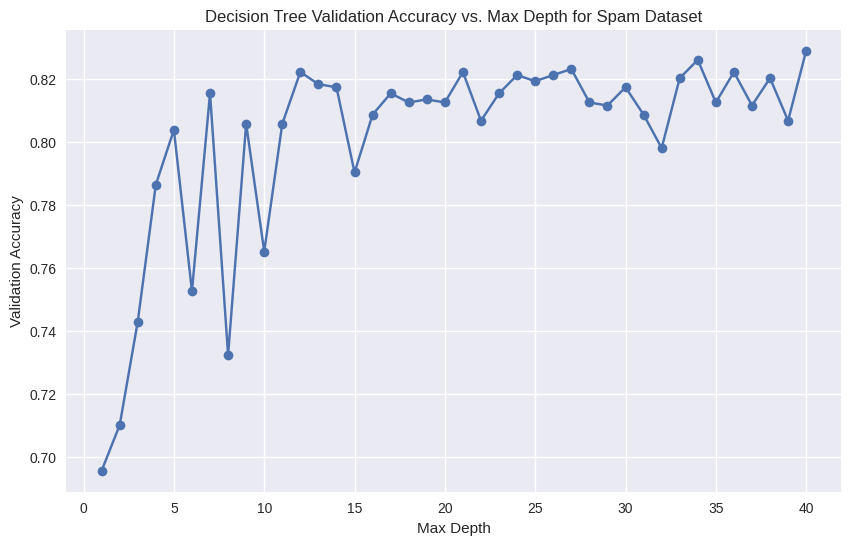

Best Max Depth: 40
Corresponding Validation Accuracy: 0.8290


In [12]:
from sklearn.metrics import accuracy_score

val_accuracies = []
max_depths = list(range(1, 41))

# Convert to numpy arrays if they are not already
X_train_spam_split_np = np.array(X_train_spam_split)
X_val_spam_split_np = np.array(X_val_spam_split)
y_train_spam_split_np = np.array(y_train_spam_split)
y_val_spam_split_np = np.array(y_val_spam_split)


for depth in max_depths:
    # Create and train the DecisionTree model
    dt = DecisionTree(max_depth=depth)
    dt.fit(X_train_spam_split_np, y_train_spam_split_np)

    # Predict and evaluate on the validation set
    y_pred_val = dt.predict(X_val_spam_split_np)
    accuracy = accuracy_score(y_val_spam_split_np, y_pred_val)

    # Store the accuracy
    val_accuracies.append(accuracy)

# Plot validation accuracy vs. max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depths, val_accuracies, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Decision Tree Validation Accuracy vs. Max Depth for Spam Dataset")
plt.grid(True)
plt.show()

# Find the best max_depth
best_depth_index = np.argmax(val_accuracies)
best_depth = max_depths[best_depth_index]
best_accuracy = val_accuracies[best_depth_index]

print(f"Best Max Depth: {best_depth}")
print(f"Corresponding Validation Accuracy: {best_accuracy:.4f}")

# Analysis (will be provided in the next markdown cell as requested by the overall task)